# Consigna 2
## Importación de modulos
---

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from columns_to_keep import C2K
from type_to_fix import T2F

## Carga de la tabla de metadata
---

In [2]:
data_dir = os.path.join('..', 'dataset')
data_file_name = 'datadump-20150801-20171219.csv'
full_data_file_name = os.path.join(data_dir, data_file_name)
df = pd.read_csv(full_data_file_name)
display(df.shape)

(63265, 111)

### Preprocesamiento o curación de la metadata

In [3]:
# Remuevo espacios al inicio y final del nombre de la columna
df.columns = [column.strip() for column in df.columns]

# Tomo solo las columnas que vamos a necesitar
df = df[C2K]

# Se corrigen los tipos de los datos 
df = df.astype(T2F)

display(df.shape)

(63265, 39)

## Carga la tabla de mensajes preprocesados
---

In [4]:
data_file_name = 'tiny_yup_messages_preprocessed.csv'
full_data_file_name = os.path.join(data_dir, data_file_name)
dfd = pd.read_csv(full_data_file_name)
display(dfd.shape)

(7441, 6)

## Cálculos
---
En principio, el número de sensiones unicas entre el archivo de mensajes preprocesados y el numero de sesiones en el archivo de metadata debería coicidir y corresponderse con el número total de diálogos. Sin embargo, dado que ambos cómputos no coinciden, se opta por tomar como fuente el fichero de metadata para este propósito.

In [80]:
n_dialogos = dfd.session_id.unique().shape[0]
n_sessions = df.session_id.shape[0]
n_tutors = df.tutor_id.unique().shape[0]
n_students = df.student_id.unique().shape[0]

display(f'>> Número de diálogos computados a partir del archivo de mensajes: {n_dialogos}')
display(f'>> Número de diálogos computados a partir del archivo de metadata: {n_sessions}')
display(f'>> Cantidad de tutores: {n_tutors}')
display(f'>> Cantidad de estudiantes: {n_students}')

'>> Número de diálogos computados a partir del archivo de mensajes: 257'

'>> Número de diálogos computados a partir del archivo de metadata: 63265'

'>> Cantidad de tutores: 150'

'>> Cantidad de estudiantes: 16808'

### Cálculo del número de turnos de estudiantes y tutores por dialogo
#### Pasos:

1. Cueta el numeor de turnos agrupando por `session_id` y `sent_from`
2. Se descartan las filas que no son turnos del tutor o estudiante
3. Se crea una conlumna con el el label adecuado
4. Se remueven las columnas no necesarias

In [78]:
# 1.
st_turnos = dfd.groupby(['session_id','sent_from']).count().reset_index()

# 2.
st_turnos = st_turnos[st_turnos.sent_from.isin(['student', 'tutor'])]

# 3. 
st_turnos['counts'] = st_turnos['text']

# 4.
st_turnos.drop(columns=['created_at', 'sent_to', 'content_type', 'text'], inplace=True)
display(st_turnos)

,session_id,sent_from,counts
0,300142,student,8
3,300142,tutor,17
4,300373,student,11
7,300373,tutor,17
8,300477,student,10
...,...,...,...
1133,325896,tutor,6
1135,326034,student,12
1138,326034,tutor,10
1140,326141,student,10


### Cálculo del numero total de turnos por diálogo

#### Pasos:

5. Se agrupa a partir del contenido de la columna `session_id` y se suman las coincidencias  

In [79]:
# 5.
turnos = st_turnos.groupby('session_id').sum()
display(turnos)

,counts
session_id,
300142,25
300373,28
300477,31
300551,25
300602,15
...,...
325522,38
325796,18
325896,15


### Cálculo de la media de turnos

1. Discriminada por tutor y estudiante
2. Total de turnos

In [101]:
# 1.
mean_disc = st_turnos.groupby('sent_from').mean().drop(columns='session_id')
mean_students = mean_disc.loc['student','counts']
mean_tutors = mean_disc.loc['tutor','counts']

# 2.
mean = turnos.counts.mean()

display(f'>> Media media de turnos por estudiantes {mean_students: .2f}')
display(f'>> Media media de turnos por tutores {mean_tutors: .2f}')
display(f'>> Media total de turnos estudiantes y tutores {mean:.2f}')


'>> Media media de turnos por estudiantes  10.67'

'>> Media media de turnos por tutores  11.75'

'>> Media total de turnos estudiantes y tutores 22.42'

## Histograma del total de turnos por session/dialogo

$$
Nt_{total} = Nt_{tutors} + Nt_{students}
$$

donde $Nt$ número de turnos total, por tutor y por estudiantes respectivamente

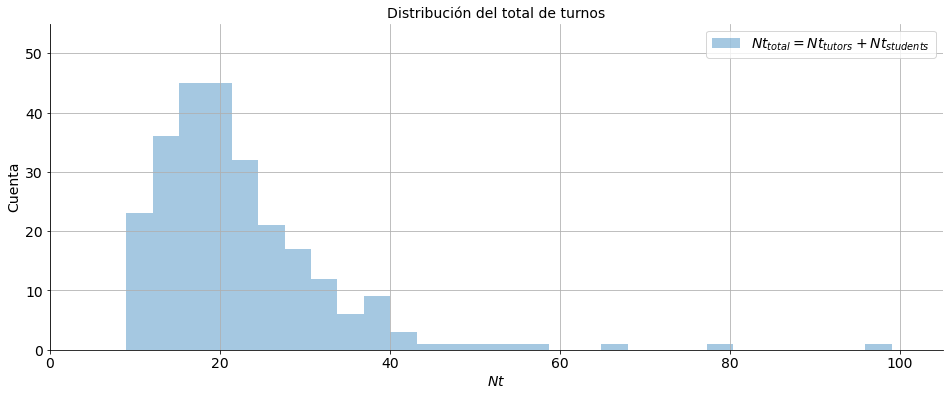

In [68]:
plt.figure(figsize=(16,6))
sns.distplot(turnos.counts.dropna(), kde=False, label=r'$Nt_{total} = Nt_{tutors} + Nt_{students}$')
plt.grid(True)
plt.title("Distribución del total de turnos", fontsize=14)
plt.xlabel(r'$Nt$', fontsize=14)
plt.ylabel('Cuenta', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.xlim([0,105])
plt.ylim([0, 55])
sns.despine()

## Histograma discrimiado por estudiantes y tutores

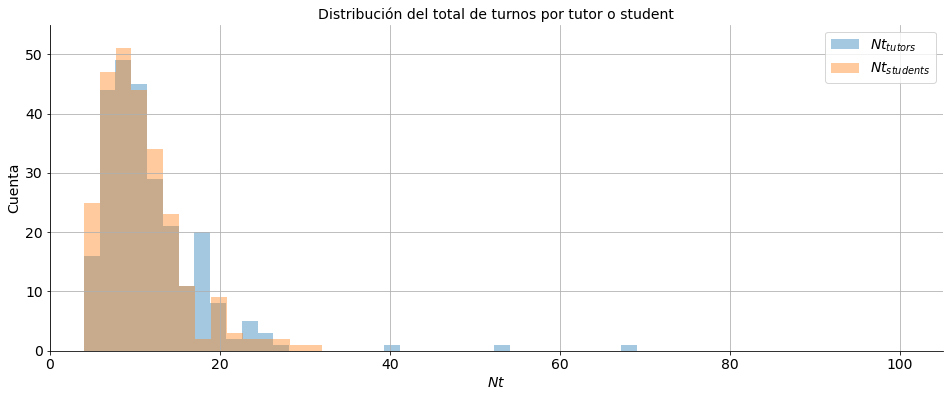

In [69]:
plt.figure(figsize=(16,6))
sns.distplot(st_turnos[st_turnos.sent_from=='tutor'].counts.dropna(), kde=False, label=r'$Nt_{tutors}$')
sns.distplot(st_turnos[st_turnos.sent_from=='student'].counts.dropna(), kde=False, label=r'$Nt_{students}$')
plt.grid(True)
plt.title("Distribución del total de turnos por tutor o student", fontsize=14)
plt.xlabel(r'$Nt$', fontsize=14)
plt.ylabel('Cuenta', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.xlim([0,105])
plt.ylim([0, 55])
sns.despine()